In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import os
import calendar
# Import the necessaries libraries
import plotly.offline as pyo
import plotly
import matplotlib.pyplot as plt
# Set notebook mode to work in offline
#pio.renderers.default='svg'
plotly.offline.init_notebook_mode(connected=True)
pio.templates.default = "plotly_dark"

import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product  

In [206]:
df = pd.read_csv('file_02.csv', thousands=',',nrows = 4635)
df = df.drop(df.index[0:200])
df['Year']=[d.split('-')[0] for d in df.Date]
df['Month']=[d.split('-')[1] for d in df.Date]
df['Day']=[d.split('-')[2] for d in df.Date]
#df['Date'] = pd.to_datetime(df['Date'])

In [207]:
total_gen = df.groupby('Date').sum()
total_gen['Total_generation'] =  total_gen.iloc[:,[2,4,6]].sum(axis = 1)

In [208]:
total_gen.head()

,index,Thermal Generation Actual (in MU),Thermal Generation Estimated (in MU),Nuclear Generation Actual (in MU),Nuclear Generation Estimated (in MU),Hydro Generation Actual (in MU),Hydro Generation Estimated (in MU),Total_generation
Date,,,,,,,,
2017-10-12,1010,2891.90,2939.66,98.66,98.83,387.16,399.90,3438.39
2017-10-13,1035,2891.90,2926.93,98.66,99.41,387.16,397.88,3424.22
2017-10-14,1060,2888.86,2896.12,98.66,99.32,387.16,381.44,3376.88
2017-10-15,1085,2899.42,2751.86,98.66,99.64,387.16,371.89,3223.39
2017-10-16,1110,2900.38,2805.88,98.66,101.42,387.16,350.16,3257.46


In [209]:
px.line(total_gen['Total_generation'],title= 'Total Generation')

In [210]:
ts = total_gen['Total_generation']
ts = pd.DataFrame(ts)
#plotMovingAverage(ts,365, plot_intervals=True)
ts.index = pd.DatetimeIndex(ts.index).to_period('D')
ts.index

PeriodIndex(['2017-10-12', '2017-10-13', '2017-10-14', '2017-10-15',
             '2017-10-16', '2017-10-17', '2017-10-18', '2017-10-19',
             '2017-10-20', '2017-10-21',
             ...
             '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11',
             '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
             '2020-03-16', '2020-03-17'],
            dtype='period[D]', name='Date', length=887, freq='D')

In [211]:
ts.index =  ts.index.astype('datetime64[ns]') 

In [212]:
data = pd.DataFrame(ts['Total_generation'].copy())
data.columns = ["y"]

In [213]:
for i in range(1, 8):
    data["lag_{}".format(i)] = data.y.shift(i)

In [214]:
data.tail(7)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
2020-03-11,3036.95,2913.42,3238.07,3258.88,3349.39,3280.94,3374.09,3438.20
2020-03-12,3215.59,3036.95,2913.42,3238.07,3258.88,3349.39,3280.94,3374.09
2020-03-13,3300.58,3215.59,3036.95,2913.42,3238.07,3258.88,3349.39,3280.94
2020-03-14,3257.83,3300.58,3215.59,3036.95,2913.42,3238.07,3258.88,3349.39
2020-03-15,3110.68,3257.83,3300.58,3215.59,3036.95,2913.42,3238.07,3258.88
2020-03-16,3305.46,3110.68,3257.83,3300.58,3215.59,3036.95,2913.42,3238.07
2020-03-17,3420.95,3305.46,3110.68,3257.83,3300.58,3215.59,3036.95,2913.42


In [215]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)


In [216]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

def plotModelResults(model, X_train,y_train, X_test,y_test ,plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(25, 10))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');


In [217]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [226]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    data.drop(["weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [297]:
X_train, X_test, y_train, y_test = prepareData(ts['Total_generation'], lag_start=1, lag_end=8,test_size=0.3, target_encoding=True)

In [298]:
X_test

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,is_weekend
Date,,,,,,,,
2019-06-28,3720.79,3825.18,3865.07,3796.34,3655.90,3778.54,3814.13,0
2019-06-29,3659.71,3720.79,3825.18,3865.07,3796.34,3655.90,3778.54,1
2019-06-30,3673.37,3659.71,3720.79,3825.18,3865.07,3796.34,3655.90,1
2019-07-01,3530.70,3673.37,3659.71,3720.79,3825.18,3865.07,3796.34,0
2019-07-02,3646.60,3530.70,3673.37,3659.71,3720.79,3825.18,3865.07,0
...,...,...,...,...,...,...,...,...
2020-03-13,3215.59,3036.95,2913.42,3238.07,3258.88,3349.39,3280.94,0
2020-03-14,3300.58,3215.59,3036.95,2913.42,3238.07,3258.88,3349.39,1
2020-03-15,3257.83,3300.58,3215.59,3036.95,2913.42,3238.07,3258.88,1


In [299]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[ 1.45028448,  1.93094863,  2.12315439, ...,  1.74874252,
         1.91989496, -0.63245553],
       [ 1.17438002,  1.45799343,  1.94182792, ...,  1.18804895,
         1.75670193,  1.58113883],
       [ 1.2360836 ,  1.18126094,  1.46730623, ...,  1.83012172,
         1.19435312,  1.58113883],
       ...,
       [-0.64095204, -0.44583364, -0.82916239, ..., -0.72221357,
        -0.62612732,  1.58113883],
       [-1.30564327, -0.63951919, -0.44282654, ..., -2.20646966,
        -0.7215487 , -0.63245553],
       [-0.42580258, -1.30620526, -0.63715361, ..., -1.64170713,
        -2.21018649, -0.63245553]])

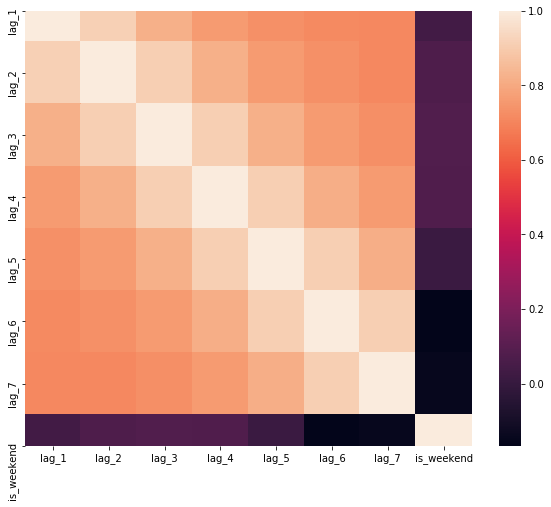

In [300]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

In [301]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

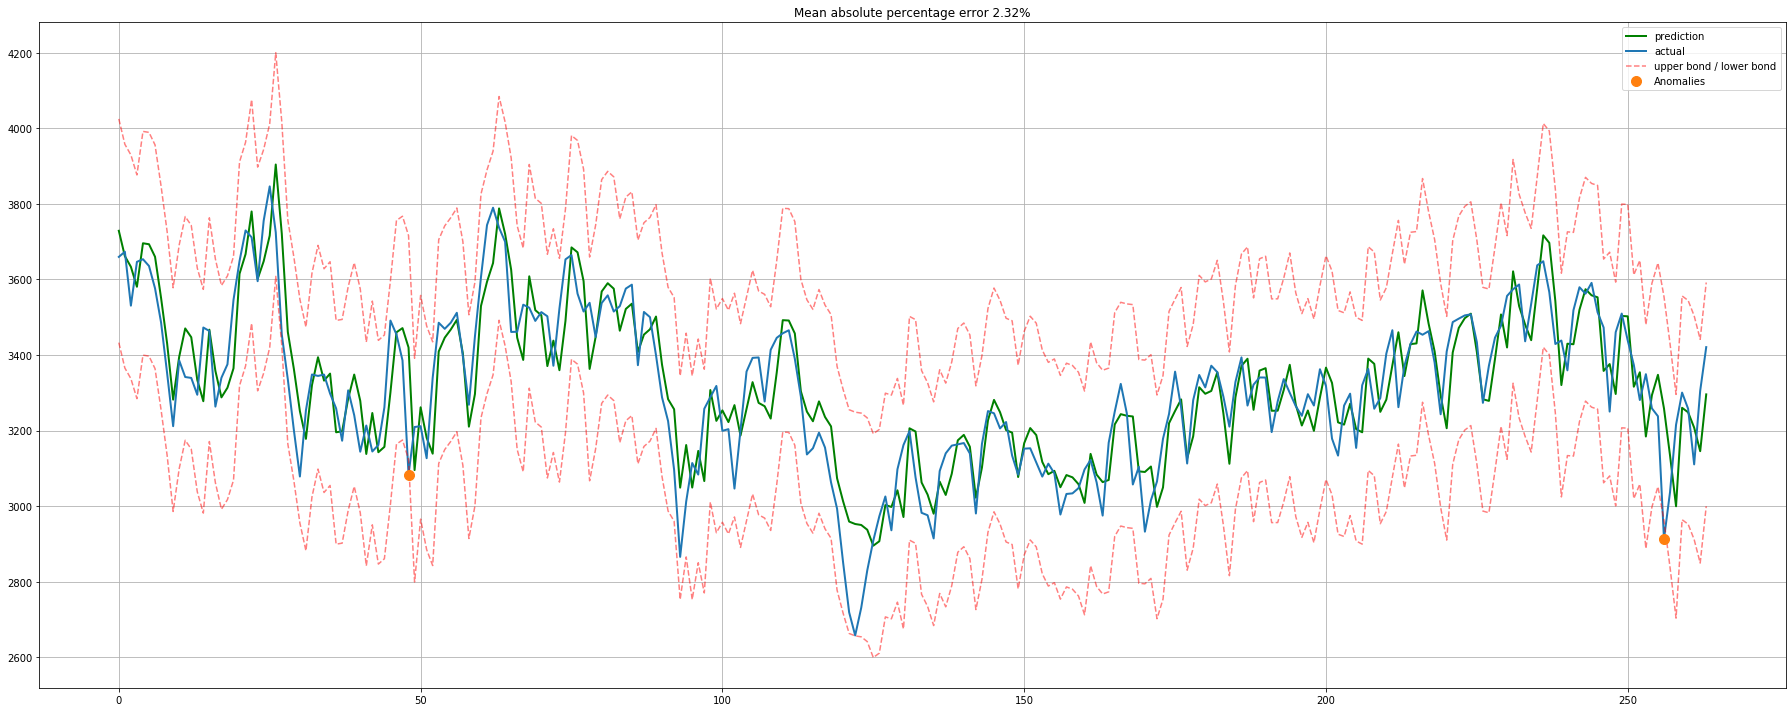

In [302]:
plotModelResults(xgb, 
                 X_train_scaled,y_train ,
                 X_test_scaled, y_test,
                 plot_intervals=True, plot_anomalies=True)

In [457]:
from datetime import timedelta
predict = pd.DataFrame()
df = pd.DataFrame(ts['Total_generation'].copy())
df.columns = ["y"]
df = df.T.reset_index()
df


Date,index,2017-10-12 00:00:00,2017-10-13 00:00:00,2017-10-14 00:00:00,2017-10-15 00:00:00,2017-10-16 00:00:00,2017-10-17 00:00:00,2017-10-18 00:00:00,2017-10-19 00:00:00,2017-10-20 00:00:00,...,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,2020-03-17 00:00:00
0,y,3438.39,3424.22,3376.88,3223.39,3257.46,3368.83,3278.81,3090.62,2988.78,...,3258.88,3238.07,2913.42,3036.95,3215.59,3300.58,3257.83,3110.68,3305.46,3420.95


In [468]:
def pred_util(days):
    predict = pd.DataFrame()
    df = pd.DataFrame(ts['Total_generation'].copy())
    df.columns = ["y"]
    df = df.T.reset_index()
    for i in range(days):
        predict = df.iloc[:,-7:]
        
        predict = predict.iloc[:, ::-1]
        
        date = predict.columns[0] + timedelta(days=1)
        if date.weekday() in [5,6]:
            predict['is_weekend'] = 1
        else:
            predict['is_weekend'] = 0

        scaled = scaler.transform(predict.iloc[:,:].values)
        df[date] = xgb.predict(scaled)[0]

    return df


def predict_generation(days):
    df = pred_util(days)
    df = df.T.iloc[1:,:]
    fig = go.Figure()
    fig.add_traces(go.Scatter(y=df.iloc[:-days,0].values,
                                  x=df.iloc[:-days,:].index,
                                  name='actual values',
                                  marker=dict(color = 'cyan')
                                 ))

    fig.update_traces(marker_line_color='rgb(255,255,255)',
                          marker_line_width=2.5, opacity=0.7)
    fig.update_layout(
                        width=1000,
                        xaxis=dict(title="Date", showgrid=False),
                        yaxis=dict(title="MU", showgrid=False),
                        legend=dict(
                                    x=0,
                                    y=1.2))

    fig.add_traces(go.Scatter(y=df.iloc[-days-1:,0].values,
                                  x=df.iloc[-days-1:,:].index,
                                  name='prediction',mode ='lines',
                                  marker=dict(color = 'lightgreen' )))


    fig.show()

In [469]:
predict_generation(days=14)